In [1]:
import pandas as pd
import json

with open("data/newsapi/uk_2_year_oct_update.json", "r") as f:
    oct_data = json.load(f)

# Load in data
with open("data/newsapi/uk_2_year.json", "r") as f:
    source_data = json.load(f) + oct_data

    # Break out into articles and concepts (NER)
    articles_list = []
    concept_list = []
    for item in source_data:
        item_concepts = item.pop("concepts", [])
        for concept in item_concepts:
            concept["article_uri"] = item["uri"]
            concept_list.append(concept)
        articles_list.append(item)

    # Build articles frame and do some basic column setting
    articles = (
        pd.json_normalize(articles_list)
        .rename(columns={"source.title": "source"})
        .assign(date=lambda x: pd.to_datetime(x["date"]))
    ).drop_duplicates(subset=["uri"])

    # Concepts frame is straightforward
    concepts = pd.json_normalize(concept_list).drop_duplicates()

FileNotFoundError: [Errno 2] No such file or directory: 'data/newsapi/uk_2_year_oct_update.json'

In [ ]:
def get_section(url):
    parts = url.split("/")
    return parts[3]


print(articles["url"].apply(get_section).value_counts())

include = ["world", "world-news", "news"]

print(f"Length before filtering {len(articles)}")
articles = articles[articles["url"].apply(get_section).isin(include)]

print(f"Length after filtering: {len(articles)}")

url
world                                  3004
news                                   1513
us-news                                1505
world-news                             1393
commentisfree                          1264
politics                                999
australia-news                          777
us                                      260
business                                210
opinion                                 144
media                                   139
uk-news                                 138
books                                   113
film                                    105
global-development                       91
tv-and-radio                             90
music                                    84
football                                 76
global-health                            68
culture                                  66
technology                               61
education                                56
law                         

# Filtering

Before undertaking LLM-processing and analysis, we need to filter the articles to ensure appropriate format and relevance. 

The objective is to isolate typical-format news articles which have a direct relevance to the conflict.

This is achieved through the following mechanisms:

## Cropping of very short and long-format articles
- Short: A typical news piece is around 2,000 characters long, and we see many in the dataset well below that. These are often intro texts to videos or links to external media, and do not represent the majority of news coverage.
- Long: Some articles are exceedingly long, up to 50,000 characters. Articles of this length pose challenges for LLM-based extraction, and aren't necessarily representative of the overall discourse on Gaza.

I make a conservative crop of the lowest and highest deciles in the batch, removing articles with character lengths that can be considered outliers.

## Ensuring relevance
As one of the largest ongoing news stories of the last two years, the conflict in Gaza is mentioned in a wide variety of contexts, often in passing. Articles are extracted from the database on the basis of keyword matching, so even a single mention of Gaza will result in an article being included.

Secondary effects of the conflict, e.g., protests, international diplomacy, are very much considered of relevance, however the dataset contains considerable numbers of articles primarily related to Ukraine, domestic politics in Western nations, broader international politics (e.g. COP28), and even recipes.

I use named-entity recognition, bundled with the data from newsapi to develop a "relevance score" to rank articles on relevance. I then develop a cut-off threshold, based on examination of the data.



|       |   body_length |
|:------|--------------:|
| count |       5910    |
| mean  |       4567.98 |
| std   |       3316.27 |
| min   |        362    |
| 25%   |       2580.25 |
| 50%   |       4108.5  |
| 75%   |       5582.75 |
| max   |      45948    |


<Axes: >

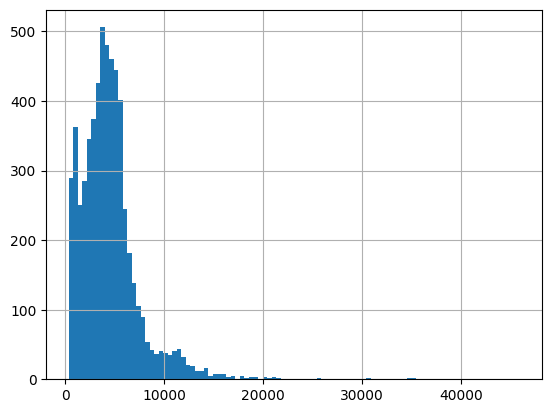

In [ ]:
articles["body_length"] = articles["body"].str.len()
print(articles["body_length"].describe().to_markdown())

articles["body_length"].hist(bins=100)

Top decile: 7773.600000000002
Bottom decile: 1190.9
Total articles before filtering: 5910
Total articles after filtering: 4728


<Axes: >

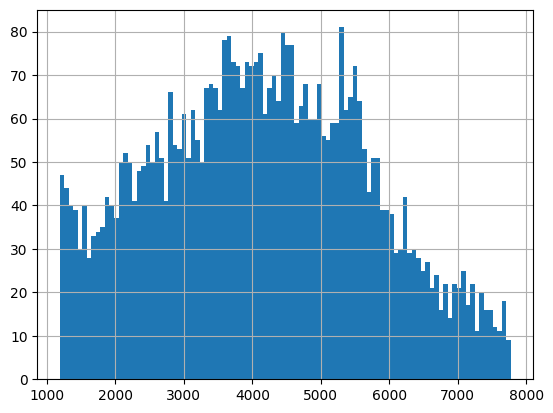

In [39]:
# Get top and bottom deciles
top_decile = articles["body_length"].quantile(0.9)
bottom_decile = articles["body_length"].quantile(0.1)

print(f"Top decile: {top_decile}")
print(f"Bottom decile: {bottom_decile}")

print(f"Total articles before filtering: {len(articles)}")

# Filter by deciles
articles = articles[
    (articles["body_length"] <= top_decile) & (articles["body_length"] >= bottom_decile)
]

print(f"Total articles after filtering: {len(articles)}")

articles["body_length"].hist(bins=100)

# Ensuring relevant articles
We want to make sure that all the articles we're looking at are focussed on Gaza. This will not be the case on the whole dataset, as the data results from a search keyword matches.

In [41]:
top_concepts = (
    concepts[concepts["article_uri"].isin(articles["uri"].to_list())][
        ["uri", "label.eng"]
    ]
    .value_counts()
    .reset_index()
    .head(25)["label.eng"]
    .values
)

In [42]:
# I take the top 25 concepts and manually filter to the relevant ones
# Removing those that are not directly related to the Gaza conflict
# This is admittedly somewhat subjective, I considered removing
# "Hostage", "Terrorism", "Antisemitism", and "Genocide" as they could
# Apply in a lot of other contexts, but they are also very relevant to the current
# conflict so I have kept them in.

# The most important ones to remove are things like "United Kingdom", "United States",
# "Donald Trump", "Keir Starmer", etc., where there's a much, much broader news agenda relating
# to these entities that is not related. One of the big problems I had in the first pass was dealing
# with the Trump show.


relevant_concepts = [
    "Gaza Strip",
    "Israel",
    "Hamas",
    "Palestinians",
    "Israel Defense Forces",
    # "United Kingdom",
    "Benjamin Netanyahu",
    "Ceasefire",
    "Terrorism",
    # "Donald Trump",
    "United Nations",
    "Middle East",
    # "Joe Biden",
    "Jews",
    "Hostage",
    "United States",
    "Humanitarian aid",
    "Iran",
    "Airstrike",
    "Prime Minister of Israel",
    "Antisemitism",
    "Egypt",
    "Lebanon",
    # "Australia",
    # "White House",
]
regional_conflict = ["Yemen", "Syria"]

relevant_concepts += regional_conflict

In [43]:
# Applying the scoring

# Building relevance scoring table
relevance_scoring = (
    concepts[concepts["label.eng"].isin(relevant_concepts)]
    .groupby("article_uri")["score"]
    .sum()
)

# The scores will be biased towards longer articles with more concepts,
# so we normalise by the length of the article

article_lengths = articles.set_index("uri")["body"].str.len()


relevance_scoring = (
    pd.concat([relevance_scoring, article_lengths], axis=1, join="outer")
    .merge(articles.set_index("uri")["title"], left_index=True, right_index=True)
    .rename(columns={"body": "body_length"})
)

# Filling NA with 0, and calculating normalised score
relevance_scoring = relevance_scoring.fillna(0).assign(
    score=lambda x: x["score"] / x["body_length"]
)


# Min-max normalisation to get a 0-1 score
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
relevance_scoring["score"] = scaler.fit_transform(relevance_scoring[["score"]])

In [44]:
# Cut into 0, 0.02, 0.04, 0.06, 0.08, 0.09, 0.1, 0.1+
relevance_scoring["binned"] = pd.cut(
    relevance_scoring["score"],
    bins=[-0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 1],
    labels=[
        "0-0.05",
        "0.05-0.06",
        "0.06-0.07",
        "0.07-0.08",
        "0.08-0.09",
        "0.09-0.1",
        "0.1-0.15",
        "0.15+",
    ],
)

# Sample five from each bin
for label, group in relevance_scoring.groupby("binned"):
    print(f"### {label} ###")
    print(
        group.sample(25, random_state=123)[["score", "title"]]
        .sort_values(by="score", ascending=True)
        .to_markdown(index=False)
    )
    print("\n\n")

### 0-0.05 ###
|      score | title                                                                                       |
|-----------:|:--------------------------------------------------------------------------------------------|
| 0.00297146 | Ed Davey is clueless about his own voters                                                   |
| 0.00989603 | 'Cliched': Turkish-Germans react as president brings kebab on Istanbul trip                 |
| 0.0146949  | Former CPS chief says clampdown on protests risks creating 'thought crimes'                 |
| 0.0149531  | 'A duty to intervene': the former UK government lawyer at centre of pro-Palestine protests  |
| 0.0188071  | Putin is preparing for nuclear war                                                          |
| 0.0194376  | Teacher who held placard depicting Sunak and Braverman as coconuts found not guilty         |
| 0.0194474  | Modi eyes 'super majority' amid fears he will change India's constitution                   |
| 0.

/tmp/ipykernel_21461/3335913764.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, group in relevance_scoring.groupby("binned"):


Looking at the articles, we can see that a cut-off of 0.093 seems to be reasonable, as we start getting relevant articles from that point onwards. Below that, the articles are mostly not relevant.

It also neatly matches a change in the distribution.

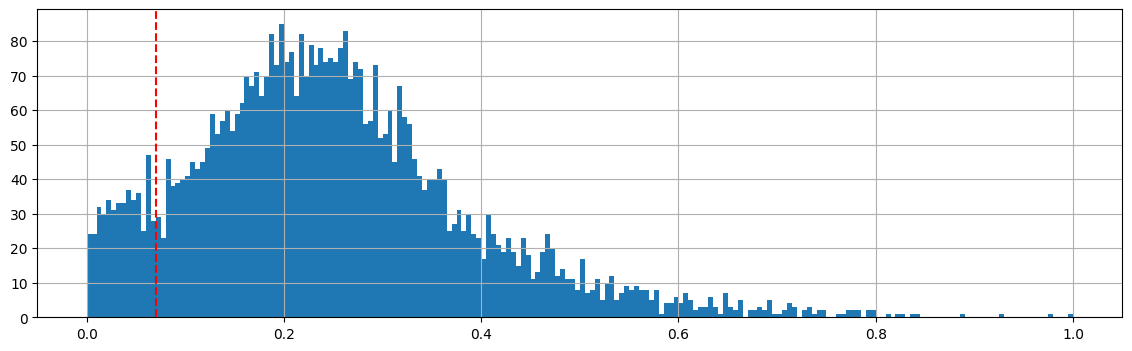

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 4))
relevance_scoring["score"].hist(bins=100, ax=ax)

ax.axvline(x=0.07, color="red", linestyle="--")

In [46]:
articles["relevance_score"] = articles["uri"].map(relevance_scoring["score"])

print(f"Length before filtering: {len(articles)}")
articles = articles[articles.relevance_score >= 0.07]
print(f"Length after filtering: {len(articles)}")

Length before filtering: 4728
Length after filtering: 4280


# Saving

In [47]:
# Write back raw filtered data

with open("data/newsapi/uk_2_year_filtered.json", "w") as f:
    filtered_articles = [i for i in source_data if i["uri"] in articles["uri"].values]
    json.dump(filtered_articles, f, ensure_ascii=False, indent=4)

In [ ]:
# Preparing prompt for quote extraction
from prep_for_llm import create_request

PROMPT = """
Extract quotes from the following article and return as structured JSON using the following fields.
    name: The full name of the person being quoted
            - If the person is a spokesperson for an organisation, leave blank and set organisation to the organisation they represent.
            - If the person is a spokesperson for a public figure, set the name as that of the public figure and set organisation to the organisation they represent.
            - Do not use a person's first or last name only, unless they are only referred to that way in the article.
            - Even then, if they are famous (e.g., "Donald Trump", "Joe Biden"), always use their full name.
    organisation: The organisation represented by the speaker, 
                  - Use the full name of the organisation rather than just the acronym.
    role: The speaker's position within that organisation, if given in the article.
    nationality: The nationality of the speaker, if known, as a 3-letter country code e.g. USA, GBR, ISR, PLE.
                    - Return an empty string if unknown.
                    - If the quote is from an organisation, infer nationality where possible:
                        - This may be from the name (e.g., "Scotland Yard" -> "GBR")
                        - Or context, for example a political party or health ministry will be from the country it is based in.
    quote: The text of the quote, if the quote breaks across the sentence, merge it into on single quote,
    message: A summary of the quote, written so that it can be understood out of context. 
             Do not include the speaker in the message, reproduce as if it was being spoken directly.
             Ensure that the message can be understood independently of the article, and that all subjects of the message are clear. 
                For example:
                    - do just not say "I agree with the government's decision", say "I agree with the German government's decision to increase funding for healthcare".
                    - do not just say "The report is very important", say "The report, published by Greenpeace, which is about climate change, is very important".

There may be several or no quotes in the article, please ensure that you return all quotes. One speaker may have several quotes.

Include direct quotes only, do not include paraphrased quotes.

Here is the article:
"""

requests = []
for record in filtered_articles:
    requests.append(create_request(record, prompt=PROMPT))

# Write as jsonl
with open("data/newsapi/uk_2_year_filtered_for_llm.jsonl", "w") as f:
    for req in requests:
        f.write(json.dumps(req) + "\n")